## CampussBBS 类型

In [162]:
%%writefile campusbbs.py

"""
TODO List:
-----------
 + 研究一下 G.node 别人是怎么写的



"""

import pandas as pd
import networkx as nx
from datetime import timedelta


class CampusBBS(object):

    def __init__(self, campus_name, *time_args, from_pickle=True): # TODO 若不存在 df 应该是返回空的dataframe而不是报错
        """ 从数据库文件中读取数据构建 CampusBBS 类型
        ----
        为了避免由于版本迭代而造成 pickle 文件无法读取，在 ./csv 路径下存储了对应高校的 csv 文件，
        默认从 ./pickle 路径下读取 pickle 文件（form_pickle=True）可以提高读取效率.
        
        -----
        Args:
            campus_name: 高校名称英文缩写，不区分大小写
            from_pickle: 是否从 pickle 文件读取，False 则读取 csv 文件
            *time_args: 起止时间参数，若给出必须同时指定起始和终止时间戳
            
        -----
        return:
            CampusBBS 类型数据
            
        -----
        example:
            shu = CampusBBS('shu', 2011) # 读取 2011 年 shu 实例
            shu = CampussBBS('shu', '2011/2/4','2011/2/9') # 读取 2011/2/4 - 2011/2/9(包括)时间内 shu 实例
            
        """
        self.name = str.upper(campus_name)
        try:
            # 原始数据已经删掉 post_id 为空的行
            if from_pickle:
                df = pd.read_pickle('./pickle/data_' + str.lower(campus_name) +'.pkl')
            else:
                df = pd.read_csv('./csv/data_'+ str.lower(campus_name) +'.csv', index_col='post_time', parse_dates=['post_time'], infer_datetime_format=True)
        except:
            raise KeyError("高校 %s 在数据库中不存在!" % campus_name)
            
        if time_args:
            if len(time_args)==1:
                self.df = df[str(time_args[0])].copy()
            elif len(time_args)==2:
                self.df = df[str(time_args[0]):str(time_args[1])].copy()
            else:
                raise KeyError("时间参数错误，必须指定一个或两个时间参数！")
        else:
            self.df = df   
            
        self.start_time = self.df.index.min()
        self.end_time = self.df.index.max()


    def number_of_users(self): 
        """统计某一时段论坛内出现的不同的 ID 数目 
        """
        post_id_set = set(self.df.post_id.unique())
        target_id_set = set(self.df.target.dropna().unique())
        return len(post_id_set.union(target_id_set))
    
    def number_of_boards(self):
        """统计某一时段论坛版块总数
        """
        try:
            return self.df.board_name_en.nunique()
        except:
            return self.df.board_name_cn.nunique()

    def number_of_threads(self):
        """统计某一时段论坛帖子总数
        """
        return self.df.thread_uid.nunique()

    
    def describe(self):
        """打印当前时间段内的论坛信息
        """
        print("当前高校： %s" % self.name)
        print("当前时段起始日期： %s" % self.start_time)
        print("当前时段结束日期： %s" % self.end_time)
        print("当前时段内总用户数：%d" % self.number_of_users())
        print("当前时段内总版块数：%d" % self.number_of_boards())
        print("当前时段内总帖子数：%d" % self.number_of_threads())
    
    
    def _user2user_graph(self, weight=True, self_loop=False): # TODO 使用 for 效率太低
        """用户和用户间构建的简单无向图
        
        允许存在用户和用户自身的连边，两用户之间只存在一条边，默认为加权网络，权重为交互
        次数，若设置为 False， 则返回简单无向无权网络
        
        Args:
            weight：是否为有权网络.
        return:
            networkx.Graph 类型的简单无向网络. 
            连边属性：
                weight: 用户间交互次数
                time: 用户交互时间戳
        """
        G = nx.Graph()
        for post_time, post in self.df.iterrows():
            n0 = post.post_id
            n1 = post.target
            if n0!=n1 or self_loop: # 只有同时为 False 才不进入连边
                if G.has_edge(n0, n1):
                    G[n0][n1]['weight'] += 1
                else:
                    G.add_edge(n0,n1, weight=1)
                    G[n0][n1]['time'] = post_time
        return G
        
    
    def user2user_graph(self, weight=True, self_loop=False): # TODO 结构过于复杂，应删掉子函数，两列变一列的映射
        """用户和用户间构建的简单无向图
        
        允许存在用户和用户自身的连边，两用户之间只存在一条边，默认为加权网络，权重为交互
        次数，若设置为 False， 则返回简单无向无权网络
        
        Args:
            weight：是否为有权网络.
        return:
            networkx.Graph 类型的简单无向网络. 
            连边属性：
                weight: 用户间交互次数
                time: 用户交互时间戳
        """ 
        df = self.df.dropna(subset=['target']).copy()
        
        if not self_loop: # 删除自己回复自己的
            df = df[df.post_id != df.target].copy()
        def _to_edge_tuple(x):
            if x['post_id'] > x['target']:
                return (x['target'], x['post_id'])
            else:
                return (x['post_id'], x['target'])
        df['edge'] = df.apply(_to_edge_tuple, axis=1) #生成无序边元组
        weight_series =  df.groupby('edge').size()
        df = pd.merge(df, weight_series.to_frame('weight').reset_index())
        G = nx.from_pandas_edgelist(df,'post_id','target',edge_attr=['weight'])
        
        return G
    
    def user2board_bigraph(self): # TODO
        pass
    
    
    
    
    
    
    
    
    
    
    
    
    
    def df_user(self):
        return self.df_all.set_index(['post_id', self.df_all.index])

    def df_with_resolution_generator(self, resolution):
        """
        最小分辨率为'D'（天）
        :param resolution:
        :return:
        """
        for period in self.df_all.resample(resolution, kind='period').size().index:
            start_timestamp = period.to_timestamp(how='start')
            end_timestamp = period.to_timestamp(how='end')
            df = self.df_all.loc[start_timestamp: end_timestamp + timedelta(days=1)]
            if resolution=='Y':
                df.name = str(start_timestamp.year)
            if resolution=='M':
                df.name = str(start_timestamp.year) + '-' + str(start_timestamp.month)
            if resolution=='W':
                df.name = str(start_timestamp.year) + '-W' +str(start_timestamp.week)
            if resolution=='D':
                df.name = str(start_timestamp.date())
            yield df

    def UserGraph_generator(self, resolution, graph_type='undirected_graph'):
        """
        不同时间分辨率下切分 df_all 得到的网络
        :param resolution:
        :param user_feature:
        :param create_using: 网络类型
        :return:
        """
        for df in self.df_with_resolution_generator(resolution):
           # df = df.dropna(subset=['reply_id']).copy() #删除没有回复的孤立点
            name = df.name
            def to_edge_tuple(x):
                if x['post_id'] > x['reply_id']:
                    return (x['reply_id'], x['post_id'])
                else:
                    return (x['post_id'], x['reply_id'])

            if graph_type == 'undirected_graph':
                df['edge'] = df.apply(to_edge_tuple, axis=1) #生成无序边元组
            if graph_type == 'directed_graph':
                df['edge'] = df[['post_id', 'reply_id']].apply(tuple, axis=1) # 生成有序边元祖
            weight_series =  df.groupby('edge').size()
            df = pd.merge(df, weight_series.to_frame('weight').reset_index())

            if graph_type == 'undirected_graph':
                G = nx.from_pandas_edgelist(df,'post_id','reply_id',edge_attr=['weight'])
            if graph_type == 'directed_graph':
                G = nx.from_pandas_edgelist(df, 'post_id', 'reply_id', edge_attr=['weight'],create_using=nx.DiGraph())
            G.name = name
            yield G

    def query_board(self, board_name_cn, period=None): # TODO 检查
        if not period:
            return self.df_all[self.df_all.board_name_cn == board_name_cn]
        else:
            return self.df_all[period][self.df_all[period].board_name_cn == board_name_cn]

    def query_user_post(self, post_id, period='all'): # TODO 检查
        if not period:
            return self.df_all[self.df_all.post_id == post_id]
        else:
            return self.df_all[period][self.df_all[period].post_id == post_id]

Overwriting campusbbs.py


In [163]:
%%writefile ./graph/disparity.py

'''
This module implements the disparity filter to compute a significance score of edge weights in networks
'''

import networkx as nx
import numpy as np
from scipy import integrate


def disparity_filter(G, alpha=0.05, weight='weight'): # TODO 有向图没检查
    ''' Compute significance scores (alpha) for weighted edges in G as defined in Serrano et al. 2009
        Args
            G: Weighted NetworkX graph
        Returns
            Weighted graph with a significance score (alpha) assigned to each edge
        References
            M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    '''
    
    if nx.is_directed(G): #directed case    
        N = nx.DiGraph()
        for u in G:
            
            k_out = G.out_degree(u)
            k_in = G.in_degree(u)
            
            if k_out > 1:
                sum_w_out = sum(np.absolute(G[u][v][weight]) for v in G.successors(u))
                for v in G.successors(u):
                    w = G[u][v][weight]
                    p_ij_out = float(np.absolute(w))/sum_w_out
                    alpha_ij_out = 1 - (k_out-1) * integrate.quad(lambda x: (1-x)**(k_out-2), 0, p_ij_out)[0]
                    N.add_edge(u, v, weight = w, alpha_out=float('%.7f' % alpha_ij_out))
                    
            elif k_out == 1 and G.in_degree(G.successors(u)[0]) == 1:
                #we need to keep the connection as it is the only way to maintain the connectivity of the network
                v = G.successors(u)[0]
                w = G[u][v][weight]
                N.add_edge(u, v, weight = w, alpha_out=0., alpha_in=0.)
                #there is no need to do the same for the k_in, since the link is built already from the tail
            
            if k_in > 1:
                sum_w_in = sum(np.absolute(G[v][u][weight]) for v in G.predecessors(u))
                for v in G.predecessors(u):
                    w = G[v][u][weight]
                    p_ij_in = float(np.absolute(w))/sum_w_in
                    alpha_ij_in = 1 - (k_in-1) * integrate.quad(lambda x: (1-x)**(k_in-2), 0, p_ij_in)[0]
                    N.add_edge(v, u, weight = w, alpha_in=float('%.7f' % alpha_ij_in))
        return N
    
    else: #undirected case
        B = nx.Graph()
        for u in G:
            k = len(G[u])
            if k > 1:
                sum_w = sum(np.absolute(G[u][v][weight]) for v in G[u])
                for v in G[u]: 
                    B.add_edge(u,v)
#                     print("B 中增加了边 %s %s" %(v,u))
                    w = G[u][v][weight]
                    p_ij = float(np.absolute(w))/sum_w
                    alpha_ij = (1-p_ij)**(k-1)#1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                    
                    if 'alpha' in B[u][v]:
#                         print("已经有了边 %s %s，原来的 alpha 为 （%.4f）" %(v,u,B[u][v]['alpha']))
#----                        B[u][v]['alpha'] = min(B[u][v]['alpha'], float('%.7f' % alpha_ij))
                        B[u][v]['alpha'] = min(B[u][v]['alpha'], alpha_ij)
#                         print("现在更新为 （%.4f）" %(B[u][v]['alpha']))
                    else:
#-----                        B.add_edge(u, v, weight = w, alpha=float('%.7f' % alpha_ij))
                        B.add_edge(u, v, weight = w, alpha=alpha_ij)
#                         print("没有边 %s %s, 创建这条边，alpha 为 （%.4f）" %(v,u,alpha_ij))

    return nx.Graph([(u, v, d) for u, v, d in B.edges(data=True) if d['alpha'] < alpha])

# if __name__ == '__main__':
#     G = nx.barabasi_albert_graph(100, 5)
#     for u, v in G.edges():
#         G[u][v]['weight'] = np.random.randint(1,100)
#     alpha = 0.05
#     G = disparity_filter(G)
#     G2 = nx.Graph([(u, v, d) for u, v, d in G.edges(data=True) if d['alpha'] < alpha])
#     print('alpha = %s' % alpha)
#     print('original: nodes = %s, edges = %s' % (G.number_of_nodes(), G.number_of_edges()))
#     print('backbone: nodes = %s, edges = %s' % (G2.number_of_nodes(), G2.number_of_edges()))
#     print(G2.edges(data=True))


Writing ./graph/disparity.py


In [22]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.subplots_adjust(hspace=0.4,wspace=0.6)
alpha = np.logspace(-5,-2)


<Figure size 432x288 with 0 Axes>

0.0
0.02040816326530612
0.04081632653061224
0.061224489795918366
0.08163265306122448
0.1020408163265306
0.12244897959183673
0.14285714285714285
0.16326530612244897
0.18367346938775508
0.2040816326530612
0.22448979591836732
0.24489795918367346
0.26530612244897955
0.2857142857142857
0.3061224489795918
0.32653061224489793
0.3469387755102041
0.36734693877551017
0.3877551020408163
0.4081632653061224
0.42857142857142855
0.44897959183673464
0.4693877551020408
0.4897959183673469
0.5102040816326531
0.5306122448979591
0.5510204081632653
0.5714285714285714
0.5918367346938775
0.6122448979591836
0.6326530612244897
0.6530612244897959
0.673469387755102
0.6938775510204082
0.7142857142857142
0.7346938775510203
0.7551020408163265
0.7755102040816326
0.7959183673469387
0.8163265306122448
0.836734693877551
0.8571428571428571
0.8775510204081632
0.8979591836734693
0.9183673469387754
0.9387755102040816
0.9591836734693877
0.9795918367346939
1.0


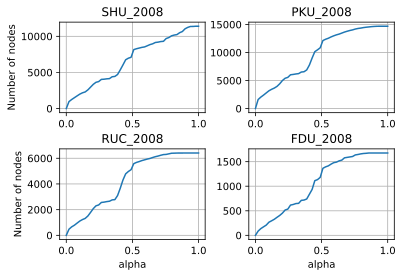

In [60]:
plt.subplots_adjust(hspace=0.4,wspace=0.3)
alpha = np.linspace(0,1,num=50)

shu = CampusBBS('shu',2008)
G0_shu_2008 = shu.user2user_graph(self_loop=False)

totle_edges = G0_shu_2008.number_of_edges()
edges = []
cc = []
nodes =[]

for a in alpha:
    print(a)
    filted_G = disparity_filter(G0_shu_2008, a)
#     edges.append(filted_G.number_of_edges())
#     filted_G = max(nx.connected_component_subgraphs(filted_G), key=len)
#     cc.append(nx.average_clustering(filted_G))
    nodes.append(filted_G.number_of_nodes())
    
plt.subplot(221)
plt.title('SHU_2008')
plt.plot(alpha,nodes)
plt.grid(True)
plt.ylabel('Number of nodes')


#----------------------------------------------------------------

pku = CampusBBS('pku',2008)
G0_pku_2008 = pku.user2user_graph(self_loop=False)

totle_edges = G0_pku_2008.number_of_edges()
edges = []
cc = []
nodes = []
for a in alpha:
    filted_G = disparity_filter(G0_pku_2008, a)
#     edges.append(filted_G.number_of_edges())
#     filted_G = max(nx.connected_component_subgraphs(filted_G), key=len)
#     cc.append(nx.average_clustering(filted_G))
    nodes.append(filted_G.number_of_nodes())

plt.subplot(222)
plt.title('PKU_2008')
plt.plot(alpha,nodes)
plt.grid(True)

#-------------------------------------------------------------------


ruc = CampusBBS('RUC',2008)
G0_ruc_2008 = ruc.user2user_graph(self_loop=False)


totle_edges = G0_ruc_2008.number_of_edges()
edges = []
cc = []
nodes = []

for a in alpha:
    filted_G = disparity_filter(G0_ruc_2008, a)
#     edges.append(filted_G.number_of_edges())
#     filted_G = max(nx.connected_component_subgraphs(filted_G), key=len)
#     cc.append(nx.average_clustering(filted_G))
    nodes.append(filted_G.number_of_nodes())
    
plt.subplot(223)
plt.title('RUC_2008')
plt.plot(alpha,nodes)
plt.grid(True)
plt.xlabel('alpha')
plt.ylabel('Number of nodes')

#----------------------------------------------------------------------

fdu = CampusBBS('FDU',2008)
G0_fdu_2008 = fdu.user2user_graph(self_loop=False)

totle_edges = G0_fdu_2008.number_of_edges()
edges = []
cc = []
nodes=[]
for a in alpha:
    filted_G = disparity_filter(G0_fdu_2008, a)
    nodes.append(filted_G.number_of_nodes())
#     edges.append(filted_G.number_of_edges())
#     try:
#         filted_G = max(nx.connected_component_subgraphs(filted_G), key=len)
#         cc.append(nx.average_clustering(filted_G)) 
#     except:
#         cc.append(0.0)
    

    
plt.subplot(224)
plt.title('FDU_2008')
plt.plot(alpha,nodes)
plt.grid(True)
plt.xlabel('alpha')

plt.savefig('alpha_numofnodes.pdf_0-1.pdf')

In [62]:
shu = CampusBBS('shu',2008)

In [64]:
G0 = shu.user2user_graph()

In [98]:
G = disparity_filter(G0,alpha=10**(-3.5))
G = max(nx.connected_component_subgraphs(G), key=len)

In [100]:
for n1, n2, d in G.edges(data=True):
    for att in ['alpha']:
        d.pop(att, None)

In [101]:
nx.write_edgelist(G,path='shu_backone_2008.csv',data=False)

In [103]:
nx.write_gexf(G, 'shu_backone_2008.gexf')

In [107]:
nx.average_clustering(G,)

0.019182537634835625

In [130]:
G.number_of_edges()

1108

In [111]:
weight=[]
for (u, v, c) in G.edges.data('weight'):
    weight.append(c)

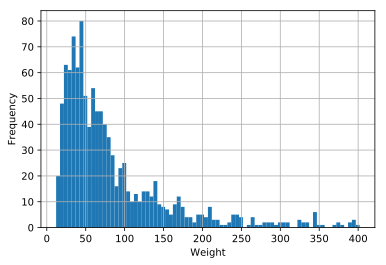

In [128]:
binwidth = 5
bins=range(min(weight), 400 + binwidth, binwidth)
plt.hist(weight,bins=bins)
plt.grid()
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.savefig('weight.pdf')

In [118]:
max(weight)

1966

In [121]:
nx.write_gexf(max(nx.connected_component_subgraphs(G0), key=len),'shu_2008.gexf')

In [157]:
fdu = CampusBBS('fdu',2007,2011)

In [159]:
fdu.describe()

当前高校： FDU
当前时段起始日期： 2007-01-01 00:00:18
当前时段结束日期： 2011-12-31 23:59:37
当前时段内总用户数：25270
当前时段内总版块数：211
当前时段内总帖子数：92285


In [ ]:
!rm 